<a href="https://colab.research.google.com/github/nishuchy/AI-works/blob/main/yolomodelcataractdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import shutil

# Remove existing contents from the mountpoint
if os.path.exists('/content/drive'):
  shutil.rmtree('/content/drive')

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import os

def remove_flash(img):
    """
    Detect & remove flash glare using adaptive threshold + inpainting
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Adaptive bright region detection
    thresh_val = max(220, int(np.percentile(gray, 99)))  # dynamic threshold
    _, mask = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)

    # Dilate mask to cover edges
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)

    # Inpaint glare regions
    cleaned = cv2.inpaint(img, mask, 7, cv2.INPAINT_TELEA)
    return cleaned


def process_single_image(input_path, output_path):
    img = cv2.imread(input_path)
    if img is None:
        print(f"[ERROR] Cannot read image: {input_path}")
        return

    cleaned = remove_flash(img)
    cv2.imwrite(output_path, cleaned)
    print(f"[OK] Processed and saved to {output_path}")


def process_directory(input_dir, output_dir):
    """
    Process all images in a directory and save to another directory
    """
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            process_single_image(input_path, output_path)

    print("✅ All images processed and saved to:", output_dir)


if __name__ == "__main__":
    input_dir = "/content/drive/MyDrive/processed_images/test/normal"
    output_dir = "/content/drive/MyDrive/processed_images_flashremove/test/normal"

    process_directory(input_dir, output_dir)


[OK] Processed and saved to /content/drive/MyDrive/processed_images_flashremove/test/normal/image_273.png
[OK] Processed and saved to /content/drive/MyDrive/processed_images_flashremove/test/normal/image_300.png
[OK] Processed and saved to /content/drive/MyDrive/processed_images_flashremove/test/normal/image_287.png
[OK] Processed and saved to /content/drive/MyDrive/processed_images_flashremove/test/normal/image_281.png
[OK] Processed and saved to /content/drive/MyDrive/processed_images_flashremove/test/normal/image_263.png
[OK] Processed and saved to /content/drive/MyDrive/processed_images_flashremove/test/normal/image_258.png


KeyboardInterrupt: 

remove flash and copy images and json to another folder

In [ ]:
import cv2
import numpy as np
import os
import shutil  # for copying json files

def remove_flash(img):
    """
    Detect & remove flash glare using adaptive threshold + inpainting
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_val = max(220, int(np.percentile(gray, 99)))  # dynamic threshold
    _, mask = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)

    cleaned = cv2.inpaint(img, mask, 7, cv2.INPAINT_TELEA)
    return cleaned


def process_single_image(input_path, output_path):
    img = cv2.imread(input_path)
    if img is None:
        print(f"[ERROR] Cannot read image: {input_path}")
        return

    cleaned = remove_flash(img)
    cv2.imwrite(output_path, cleaned)
    print(f"[OK] Processed and saved to {output_path}")


def process_directory(input_dir, output_dir):
    """
    Process all images and copy related json files
    """
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        name, ext = os.path.splitext(filename)
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        # If it's an image → process flash removal
        if ext.lower() in ['.png', '.jpg', '.jpeg']:
            process_single_image(input_path, output_path)

            # Copy matching JSON if exists
            json_src = os.path.join(input_dir, f"{name}.json")
            json_dst = os.path.join(output_dir, f"{name}.json")
            if os.path.exists(json_src):
                shutil.copy2(json_src, json_dst)
                print(f"[OK] Copied JSON: {json_src} → {json_dst}")

        # If it's a JSON only (no image), just copy
        elif ext.lower() == '.json':
            shutil.copy2(input_path, output_path)
            print(f"[OK] Copied JSON: {input_path} → {output_path}")

    print("✅ All images and JSON files processed and saved to:", output_dir)


if __name__ == "__main__":
    input_dir = "/content/drive/MyDrive/processed_images/test/cataract"
    output_dir = "/content/drive/MyDrive/processed_images_flashremove/test/cataract"

    process_directory(input_dir, output_dir)


In [ ]:
# ==========================================================
# YOLOv8 Cataract Detection (with JSON → YOLO format conversion)
# Author: Nishu Chowdhury (2025)
# ==========================================================

!pip install ultralytics -q
import os
import json
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO

# ----------------------------------------------------------
# Configuration
# ----------------------------------------------------------
BASE_DIR = '/content/drive/MyDrive/processed_images_flashremove/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
OUTPUT_DIR = '/content/drive/MyDrive/yolo_output'

os.makedirs(OUTPUT_DIR, exist_ok=True)
for split in ['train', 'test']:
    os.makedirs(os.path.join(OUTPUT_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split, 'labels'), exist_ok=True)

# ----------------------------------------------------------
# JSON → YOLO label conversion function
# ----------------------------------------------------------
def convert_json_to_yolo(json_path, img_path, label_path, class_id):
    """Convert JSON annotation to YOLOv8 txt format."""
    with open(json_path, 'r') as f:
        data = json.load(f)

    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Image not found: {img_path}")
        return
    h, w, _ = img.shape

    yolo_lines = []
    for obj in data.get('shapes', []):
        if 'points' in obj:
            points = obj['points']
            x_coords = [p[0] for p in points]
            y_coords = [p[1] for p in points]
            xmin, xmax = min(x_coords), max(x_coords)
            ymin, ymax = min(y_coords), max(y_coords)

            # Convert to YOLO format (normalized)
            x_center = ((xmin + xmax) / 2) / w
            y_center = ((ymin + ymax) / 2) / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h

            yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}")

    # Write to label file
    with open(label_path, 'w') as out:
        out.write("\n".join(yolo_lines))

# ----------------------------------------------------------
# Convert all images and JSONs
# ----------------------------------------------------------
def process_dataset(split_dir, split_name):
    for cls_name, class_id in zip(['cataract', 'normal'], [0, 1]):
        cls_dir = os.path.join(split_dir, cls_name)
        for file in os.listdir(cls_dir):
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                img_path = os.path.join(cls_dir, file)
                json_path = img_path.replace('.png', '.json').replace('.jpg', '.json').replace('.jpeg', '.json')

                out_img_path = os.path.join(OUTPUT_DIR, split_name, 'images', f"{cls_name}_{file}")
                out_label_path = os.path.join(OUTPUT_DIR, split_name, 'labels', f"{cls_name}_{file.rsplit('.', 1)[0]}.txt")

                # Copy image
                import shutil
                shutil.copy(img_path, out_img_path)

                # Convert JSON
                if os.path.exists(json_path):
                    convert_json_to_yolo(json_path, img_path, out_label_path, class_id)
                else:
                    # Normal class may not have annotation box → create empty label
                    open(out_label_path, 'w').close()

process_dataset(TRAIN_DIR, 'train')
process_dataset(TEST_DIR, 'test')

print("✅ JSON to YOLO conversion completed!")

# ----------------------------------------------------------
# Create YOLO data.yaml
# ----------------------------------------------------------
yaml_path = os.path.join(OUTPUT_DIR, 'data.yaml')
with open(yaml_path, 'w') as f:
    f.write(f"""
train: {os.path.join(OUTPUT_DIR, 'train/images')}
val: {os.path.join(OUTPUT_DIR, 'test/images')}

nc: 2
names: ['cataract', 'normal']
""")

print("✅ data.yaml created:", yaml_path)

# ----------------------------------------------------------
# Train YOLOv8 Model
# ----------------------------------------------------------
model = YOLO('yolov8n.yaml')  # or yolov8s.yaml for better accuracy

results = model.train(
    data=yaml_path,
    epochs=20,
    imgsz=640,
    batch=16,
    name='yolov8_cataract',
    project=os.path.join(BASE_DIR, 'yolo_output')
)

# ----------------------------------------------------------
# Evaluate Model
# ----------------------------------------------------------
metrics = model.val()
print(metrics)

# ----------------------------------------------------------
# Visualize Training Performance
# ----------------------------------------------------------
results_dir = os.path.join(BASE_DIR, 'yolo_output', 'yolov8_cataract')
csv_path = os.path.join(results_dir, 'results.csv')

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("📊 Training Results Columns:", df.columns.tolist())

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
    plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
    plt.title('Box Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
    plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
    plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
    plt.title('Validation Metrics Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------
# Run Inference on Test Image
# ----------------------------------------------------------
test_image = os.path.join(OUTPUT_DIR, 'test/images', os.listdir(os.path.join(OUTPUT_DIR, 'test/images'))[0])

results = model.predict(
    source=test_image,
    conf=0.5,
    save=True,
    project=os.path.join(BASE_DIR, 'yolo_output'),
    name='yolov8_infer'
)

from IPython.display import Image, display
pred_img = os.path.join(BASE_DIR, 'yolo_output', 'yolov8_infer', os.path.basename(test_image))
display(Image(filename=pred_img))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ JSON → YOLO conversion done
✅ data.yaml created

🚀 Training YOLOv8 …
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolo_compare_output/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, e

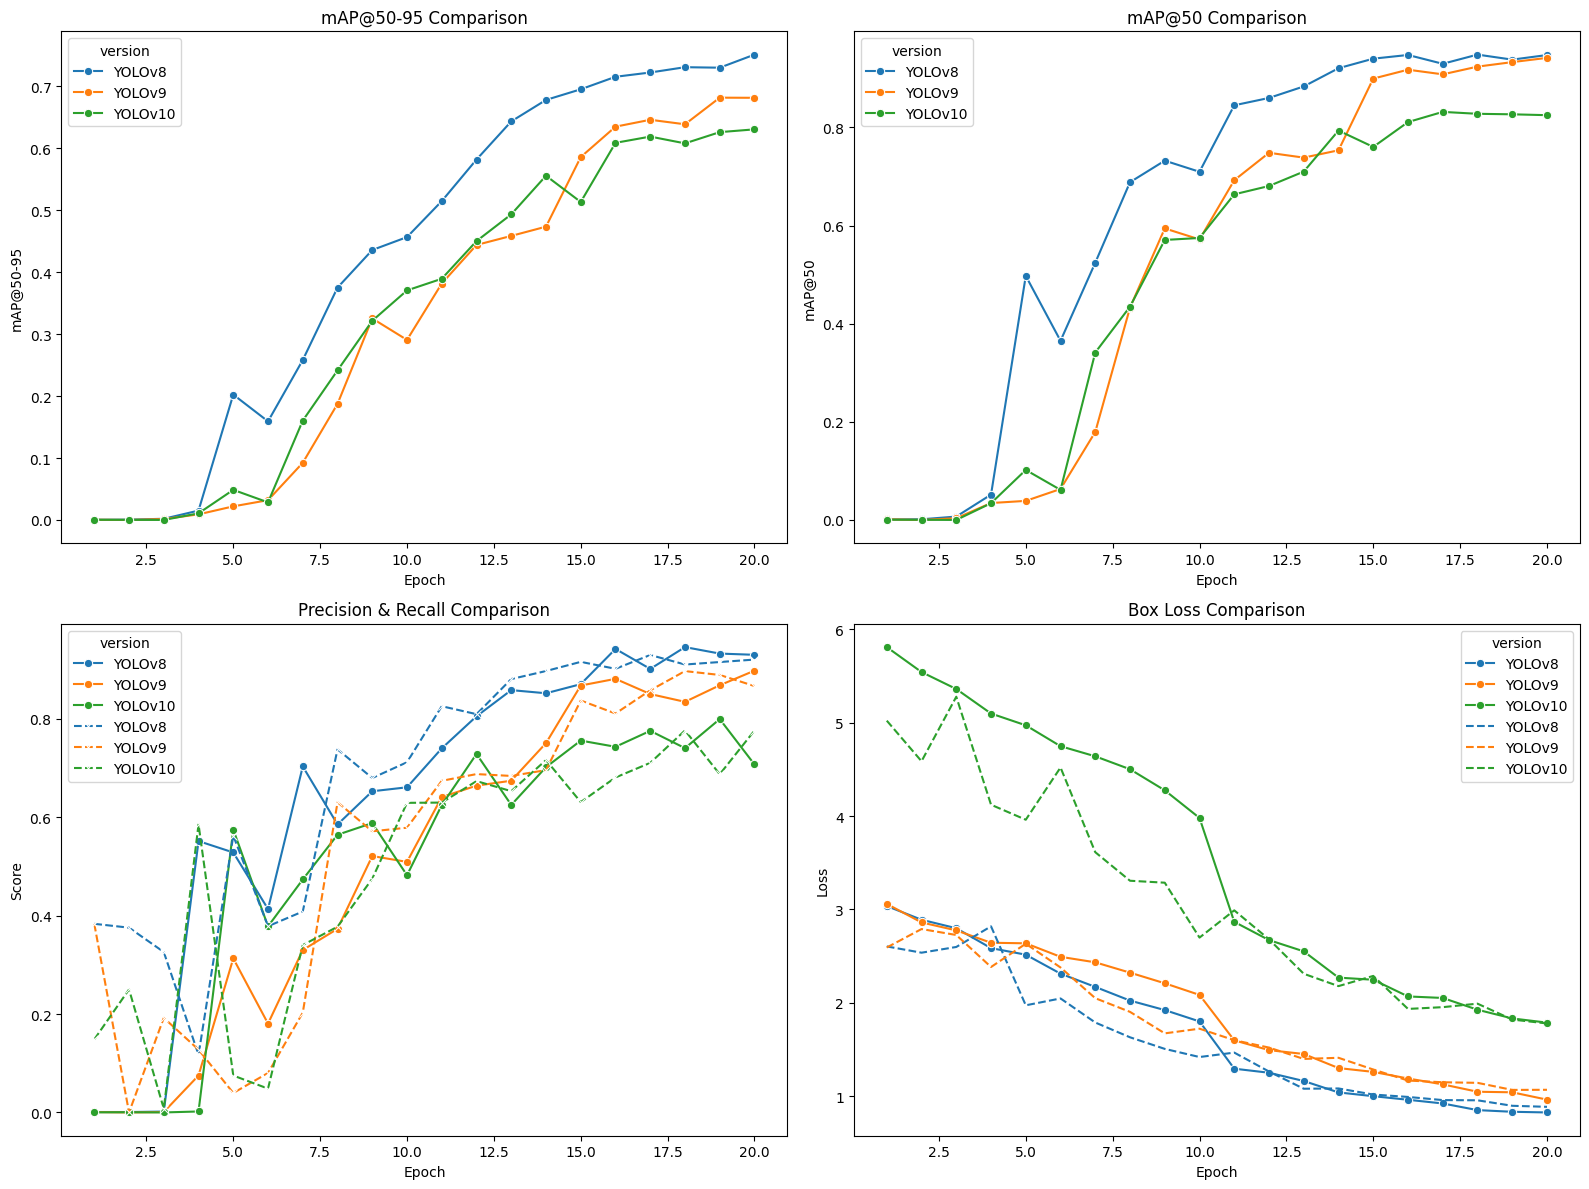


🏁 Final Metric Summary:
   Version  Precision   Recall    mAP50  mAP50-95
0   YOLOv8    0.92999  0.92031  0.94769   0.75144
1   YOLOv9    0.89779  0.86651  0.94188   0.68168
2  YOLOv10    0.70715  0.77604  0.82511   0.63073


In [3]:
# ==========================================================
# YOLOv8 vs YOLOv9 vs YOLOv10 — Cataract Detection Comparison
# Author: Nishu Chowdhury (2025)
# ==========================================================

!pip install ultralytics -q
import os
import json
import cv2
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO

# ----------------------------------------------------------
# Configuration
# ----------------------------------------------------------
BASE_DIR = '/content/drive/MyDrive/processed_images_flashremove/'
OUTPUT_DIR = '/content/drive/MyDrive/yolo_compare_output'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

os.makedirs(OUTPUT_DIR, exist_ok=True)
for split in ['train', 'test']:
    os.makedirs(os.path.join(OUTPUT_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split, 'labels'), exist_ok=True)

# ----------------------------------------------------------
# JSON → YOLO label conversion function
# ----------------------------------------------------------
def convert_json_to_yolo(json_path, img_path, label_path, class_id):
    with open(json_path, 'r') as f:
        data = json.load(f)

    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Image not found: {img_path}")
        return
    h, w, _ = img.shape

    yolo_lines = []
    for obj in data.get('shapes', []):
        if 'points' in obj:
            pts = obj['points']
            x_coords = [p[0] for p in pts]
            y_coords = [p[1] for p in pts]
            xmin, xmax = min(x_coords), max(x_coords)
            ymin, ymax = min(y_coords), max(y_coords)

            x_center = ((xmin + xmax) / 2) / w
            y_center = ((ymin + ymax) / 2) / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h

            yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}")

    with open(label_path, 'w') as out:
        out.write("\n".join(yolo_lines))

# ----------------------------------------------------------
# Convert dataset for YOLO
# ----------------------------------------------------------
def process_dataset(split_dir, split_name):
    for cls_name, class_id in zip(['cataract', 'normal'], [0, 1]):
        cls_dir = os.path.join(split_dir, cls_name)
        for file in os.listdir(cls_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(cls_dir, file)
                json_path = img_path.rsplit('.', 1)[0] + '.json'

                out_img_path = os.path.join(OUTPUT_DIR, split_name, 'images', f"{cls_name}_{file}")
                out_label_path = os.path.join(OUTPUT_DIR, split_name, 'labels', f"{cls_name}_{file.rsplit('.', 1)[0]}.txt")

                shutil.copy(img_path, out_img_path)

                if os.path.exists(json_path):
                    convert_json_to_yolo(json_path, img_path, out_label_path, class_id)
                else:
                    open(out_label_path, 'w').close()

process_dataset(TRAIN_DIR, 'train')
process_dataset(TEST_DIR, 'test')
print("✅ JSON → YOLO conversion done")

# ----------------------------------------------------------
# Create YOLO data.yaml
# ----------------------------------------------------------
yaml_path = os.path.join(OUTPUT_DIR, 'data.yaml')
with open(yaml_path, 'w') as f:
    f.write(f"""
train: {os.path.join(OUTPUT_DIR, 'train/images')}
val:   {os.path.join(OUTPUT_DIR, 'test/images')}

nc: 2
names: ['cataract', 'normal']
""")
print("✅ data.yaml created")

# ==========================================================
# Define model versions and config names
# ==========================================================
model_versions = {
    'YOLOv8': 'yolov8n.yaml',
    'YOLOv9': 'yolov9c.yaml',   # or appropriate config for 9
    'YOLOv10': 'yolov10n.yaml', # or appropriate config for 10
    # 'YOLOv11': 'yolov11n.yaml'  # or appropriate config for 11
}

results_paths = {}

# ==========================================================
# Train + Validate each version
# ==========================================================
for version, cfg in model_versions.items():
    print(f"\n🚀 Training {version} …")
    model = YOLO(cfg)
    name = f"{version.lower()}_cataract"
    results = model.train(
        data=yaml_path,
        epochs=20,
        imgsz=640,
        batch=16,
        name=name,
        project=os.path.join(OUTPUT_DIR, 'results')
    )
    metrics = model.val()
    print(f"{version} Metrics:", metrics)
    results_paths[version] = os.path.join(OUTPUT_DIR, 'results', name)

# ==========================================================
# Load results & Compare Performance
# ==========================================================
print("\n📊 Comparing all versions …")

def load_results(path, version):
    csv_path = os.path.join(path, 'results.csv')
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        df['version'] = version
        return df
    print(f"⚠️ No results.csv found for {version} at {csv_path}")
    return pd.DataFrame()

df_list = []
for version, path in results_paths.items():
    df_list.append(load_results(path, version))
df = pd.concat(df_list, ignore_index=True)

if not df.empty:
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    sns.lineplot(data=df, x='epoch', y='metrics/mAP50-95(B)', hue='version', marker='o')
    plt.title('mAP@50-95 Comparison')
    plt.xlabel('Epoch'); plt.ylabel('mAP@50-95')

    plt.subplot(2, 2, 2)
    sns.lineplot(data=df, x='epoch', y='metrics/mAP50(B)', hue='version', marker='o')
    plt.title('mAP@50 Comparison')
    plt.xlabel('Epoch'); plt.ylabel('mAP@50')

    plt.subplot(2, 2, 3)
    sns.lineplot(data=df, x='epoch', y='metrics/precision(B)', hue='version', marker='o')
    sns.lineplot(data=df, x='epoch', y='metrics/recall(B)', hue='version', marker='x', linestyle='--')
    plt.title('Precision & Recall Comparison')
    plt.xlabel('Epoch'); plt.ylabel('Score')

    plt.subplot(2, 2, 4)
    sns.lineplot(data=df, x='epoch', y='train/box_loss', hue='version', marker='o')
    sns.lineplot(data=df, x='epoch', y='val/box_loss', hue='version', linestyle='--')
    plt.title('Box Loss Comparison')
    plt.xlabel('Epoch'); plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

# ==========================================================
# Print final metric summary
# ==========================================================
summary = []
for version, dfv in zip([v for v in model_versions.keys()], df_list):
    if not dfv.empty:
        last = dfv[dfv['epoch'] == dfv['epoch'].max()].iloc[0]
        summary.append({
            'Version': version,
            'Precision': last['metrics/precision(B)'],
            'Recall': last['metrics/recall(B)'],
            'mAP50': last['metrics/mAP50(B)'],
            'mAP50-95': last['metrics/mAP50-95(B)']
        })

print("\n🏁 Final Metric Summary:")
print(pd.DataFrame(summary))